# Logistic Regression for QAM Demodulation in AWGN Channels

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code serves as:
* an exercise to demodulate QAM symbols using multiclass logistic regression

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
    
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib inline 

# use pytorch device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


Here we use a simple AWGN model and normalize the constellations to unit energy

In [10]:
constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6]), \
                  '4-test' : np.array([-1,2,0,4]) + 1j*np.array([0,0,3,0])}

# permute constellations so that it is visually more appealing with the chosen colormap
# also normalize constellation
for cname in constellations.keys():
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellations[cname])**2))
    constellations[cname] = constellations[cname][np.random.permutation(len(constellations[cname]))] * norm_factor
    

constellation = constellations['16-QAM']
n = len(constellation)

Simple AWGN channel

In [11]:
def simulate_channel(x, SNR):  
    # noise variance per step    
    sigma = np.sqrt( 0.5 * (10**(-SNR/10.0)) )

    return x + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))    

In [12]:
length = 10000

def plot_constellation(SNR):
    ti = np.random.randint(len(constellation),size=length)
    t = constellation[ti]
    r = simulate_channel(t, SNR)

    plt.figure(figsize=(6,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.scatter(np.real(r), np.imag(r), c=ti, cmap='tab20')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation (SNR = $%1.2f$\,dBm)' % (SNR))    
    
interactive_update = interactive(plot_constellation, SNR = widgets.FloatSlider(min=0.0,max=30.0,step=0.1,value=15, continuous_update=False, description='SNR (dB)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')))


output = interactive_update.children[-1]
output.layout.height = '500px'
interactive_update

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='SNR (dB)', layout=Layout(w…

Carry out gradient descent. Please insert the relevant code for yourself.

In [13]:
class logistic_regression_bias(nn.Module):
    def __init__(self, logits):
        super(logistic_regression_bias, self).__init__()
       
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, logits) 

        # Non-linearity via softmax
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Linear function, first layer
        out =  self.softmax( self.fc1(x) )
        
        return out

Main program loop, carry out 1000 iterations of gradient descent for finding the weights

In [14]:
# initialize model and copy to target device
model = logistic_regression_bias(len(constellation))
model.to(device)


# Negative Log-Likelihood Loss function, attention, requires LogSoftmax to compute logarithmic softmax outputs
loss_fn = nn.NLLLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  

# Build dataset
SNR = 19 #dB

# Transmit data (bits)
ti = np.random.randint(len(constellation),size=length)
t = constellation[ti]
# Channel output
r = simulate_channel(t, SNR)
inputs = np.column_stack((np.real(r), np.imag(r)))

# convert input vector to pytorch
inputs_torch = torch.from_numpy(inputs).float().to(device)
labels_torch = torch.from_numpy(ti).long().to(device)

n = len(constellation)


# main gradient descent loop
for i in range(10000):            
    outputs = model(inputs_torch)
    loss = loss_fn(outputs, labels_torch)
    
    # compute gradient
    loss.backward()
    
    # optimize
    optimizer.step()
    
    # reset gradients
    optimizer.zero_grad()
    
    if i % 500 == 0:
        preds = np.argmax(model(inputs_torch).detach().cpu().numpy(), axis=1)        
        error_rate = np.mean(preds != ti)
        print('Step',i,' : ',error_rate,' error_rate with loss ',loss)

Step 0  :  0.9362  error_rate with loss  tensor(2.9921, grad_fn=<NllLossBackward>)
Step 500  :  0.8257  error_rate with loss  tensor(2.4114, grad_fn=<NllLossBackward>)
Step 1000  :  0.7964  error_rate with loss  tensor(2.0812, grad_fn=<NllLossBackward>)
Step 1500  :  0.6032  error_rate with loss  tensor(1.8590, grad_fn=<NllLossBackward>)
Step 2000  :  0.3769  error_rate with loss  tensor(1.6917, grad_fn=<NllLossBackward>)
Step 2500  :  0.2099  error_rate with loss  tensor(1.5559, grad_fn=<NllLossBackward>)
Step 3000  :  0.1113  error_rate with loss  tensor(1.4399, grad_fn=<NllLossBackward>)
Step 3500  :  0.0488  error_rate with loss  tensor(1.3376, grad_fn=<NllLossBackward>)
Step 4000  :  0.0201  error_rate with loss  tensor(1.2455, grad_fn=<NllLossBackward>)
Step 4500  :  0.0083  error_rate with loss  tensor(1.1614, grad_fn=<NllLossBackward>)
Step 5000  :  0.0045  error_rate with loss  tensor(1.0838, grad_fn=<NllLossBackward>)
Step 5500  :  0.002  error_rate with loss  tensor(1.0118, 

In [ ]:
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = torch.from_numpy( np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) ).float().to(device)

decision_region = np.argmax(model(meshgrid).detach().cpu().numpy(), axis=1) / 16

plt.figure(figsize=(8,8))
#plt.contourf(mgx,mgy,decision_region.reshape(mgy.shape),cmap='tab20',vmin=0,vmax=1)
plt.scatter(meshgrid[:,0],meshgrid[:,1],c = decision_region,cmap='tab20', s=5, alpha=0.7)
plt.scatter(np.real(r), np.imag(r), c=ti, cmap='tab20')

plt.axis('scaled')
plt.xlim((-ext_max,+ext_max))
plt.ylim((-ext_max,+ext_max))
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.title('Decision regision',fontsize=16) 

Try a more _Deep-Learning_ soft of doing things with mini-batches and directly using the cross-entropy loss function

In [5]:
class logistic_regression_nosoftmax_bias(nn.Module):
    def __init__(self, logits):
        super(logistic_regression_nosoftmax_bias, self).__init__()
       
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, logits)
                   
    def forward(self, x):
        # Linear function, first layer
        return self.fc1(x) 

In [6]:
# alternative solution not using predefined layers
class logistic_regression_nosoftmax_bias(nn.Module):
    def __init__(self, logits):
        super(logistic_regression_nosoftmax_bias, self).__init__()
        
        self.weight = torch.nn.Parameter(torch.randn(2, logits))
        self.bias = torch.nn.Parameter(torch.randn(logits))
        
    def forward(self, x):
        return x @ self.weight + self.bias

In [7]:
# initialize model
model = logistic_regression_nosoftmax_bias(len(constellation))
model.to(device)

# TODO select loss function
loss_fn_cn = nn.CrossEntropyLoss()

# TODO select Adam optimizer
optimizer = optim.Adam(model.parameters())  

# Build dataset
SNR = 19 #dB


dataset_length = np.linspace(100,length, 10000)

# main gradient descent loop
for i in range(10000):       
    
    # Transmit data (bits)
    ti = np.random.randint(len(constellation),size=int(dataset_length[i]))
    t = constellation[ti]
    # Channel output
    r = simulate_channel(t, SNR)
    
    # generate classifier input
    inputs = np.column_stack((np.real(r), np.imag(r)))

    # convert input vector to pytorch    
    inputs_torch = torch.from_numpy(inputs).float().to(device)
    labels_torch = torch.from_numpy(ti).long().to(device)

    n = len(constellation)


    outputs = model(inputs_torch)
    loss = loss_fn_cn(outputs, labels_torch)
    
    # compute gradient
    loss.backward()
    
    # optimize
    optimizer.step()
    
    # reset gradients
    optimizer.zero_grad()
    
    if i % 500 == 0:
        preds = np.argmax(model(inputs_torch).detach().cpu().numpy(), axis=1)        
        error_rate = np.mean(preds != ti)
        print('Step',i,' : ',error_rate,' error_rate with loss ',loss)

Step 0  :  1.0  error_rate with loss  tensor(4.4195, grad_fn=<NllLossBackward>)
Step 500  :  0.9831932773109243  error_rate with loss  tensor(3.1908, grad_fn=<NllLossBackward>)
Step 1000  :  0.8761467889908257  error_rate with loss  tensor(2.4976, grad_fn=<NllLossBackward>)
Step 1500  :  0.7141955835962145  error_rate with loss  tensor(2.1612, grad_fn=<NllLossBackward>)
Step 2000  :  0.5764423076923076  error_rate with loss  tensor(1.9149, grad_fn=<NllLossBackward>)
Step 2500  :  0.48699029126213594  error_rate with loss  tensor(1.7223, grad_fn=<NllLossBackward>)
Step 3000  :  0.4224755700325733  error_rate with loss  tensor(1.5754, grad_fn=<NllLossBackward>)
Step 3500  :  0.285273492286115  error_rate with loss  tensor(1.4542, grad_fn=<NllLossBackward>)
Step 4000  :  0.11995073891625616  error_rate with loss  tensor(1.3509, grad_fn=<NllLossBackward>)
Step 4500  :  0.05159165751920966  error_rate with loss  tensor(1.2577, grad_fn=<NllLossBackward>)
Step 5000  :  0.023564356435643564  e

Text(0.5, 1.0, 'Decision regision')

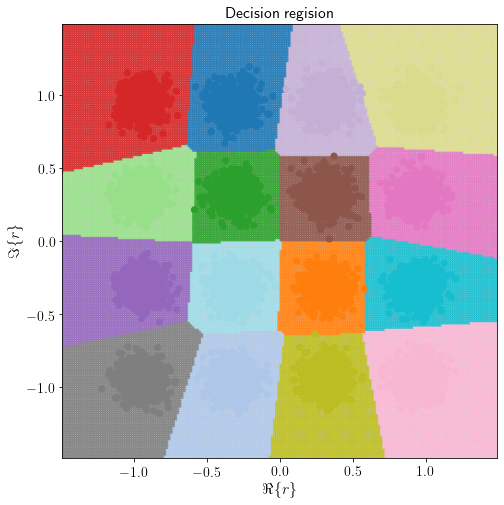

In [8]:
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = torch.from_numpy( np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) ).float().to(device)

decision_region = np.argmax(model(meshgrid).detach().cpu().numpy(), axis=1) / 16

plt.figure(figsize=(8,8))
#plt.contourf(mgx,mgy,decision_region.reshape(mgy.shape),cmap='tab20',vmin=0,vmax=1)
plt.scatter(meshgrid[:,0],meshgrid[:,1],c = decision_region,cmap='tab20', s=5, alpha=0.7)
plt.scatter(np.real(r), np.imag(r), c=ti, cmap='tab20')

plt.axis('scaled')
plt.xlim((-ext_max,+ext_max))
plt.ylim((-ext_max,+ext_max))
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.title('Decision regision',fontsize=16)